# **Import thư viện cần thiết**

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot  as plt
import seaborn            as sbn
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore') # tắt những cảnh báo

from sklearn.preprocessing import RobustScaler
from sklearn.metrics          import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from datasets import load_dataset
from scipy.stats.mstats import winsorize

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import lightgbm as lgb
from xgboost import XGBRegressor

# **Load dataset**

In [2]:

ds = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

df_train = ds['train'].to_pandas()
df_eval  = ds['eval'].to_pandas()

# **Tiền xử lý**

In [3]:

df_train['dt'] = pd.to_datetime(df_train['dt'], errors='coerce')
df_eval['dt']  = pd.to_datetime(df_eval['dt'], errors='coerce')

In [4]:
expected_cols = [
    'city_id', 'store_id', 'management_group_id',
    'first_category_id', 'second_category_id', 'third_category_id',
    'product_id', 'dt'
]

# ----- TRAIN -----
duplicate_train = df_train[df_train.duplicated(subset=expected_cols, keep=False)]

print(f"TRAIN – số dòng trùng: {duplicate_train.shape[0]}")
display(duplicate_train.sort_values(by=expected_cols).head(10))

# ----- TEST -----
duplicate_test = df_eval[df_eval.duplicated(subset=expected_cols, keep=False)]

print(f"TEST – số dòng trùng: {duplicate_test.shape[0]}")
display(duplicate_test.sort_values(by=expected_cols).head(10))


TRAIN – số dòng trùng: 0


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level


TEST – số dòng trùng: 0


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level


In [5]:
df_train.isna().sum()
df_eval.isna().sum()


city_id                0
store_id               0
management_group_id    0
first_category_id      0
second_category_id     0
third_category_id      0
product_id             0
dt                     0
sale_amount            0
hours_sale             0
stock_hour6_22_cnt     0
hours_stock_status     0
discount               0
holiday_flag           0
activity_flag          0
precpt                 0
avg_temperature        0
avg_humidity           0
avg_wind_level         0
dtype: int64

In [6]:

# Điều kiện lỗi: discount = 0 nhưng sale_amount > 0
error_condition = (df_train['discount'] == 0) & (df_train['sale_amount'] > 0)

# ---- TRAIN ----
error_train = (df_train['discount'] == 0) & (df_train['sale_amount'] > 0)
print(f"🔹 Số dòng lỗi TRAIN: {error_train.sum()}")

df_train = df_train[~error_train].copy()
df_train.reset_index(drop=True, inplace=True)

# ---- TEST / EVAL ----
error_eval = (df_eval['discount'] == 0) & (df_eval['sale_amount'] > 0)
print(f"🔹 Số dòng lỗi TEST: {error_eval.sum()}")

df_eval = df_eval[~error_eval].copy()
df_eval.reset_index(drop=True, inplace=True)



🔹 Số dòng lỗi TRAIN: 16038
🔹 Số dòng lỗi TEST: 1300


In [7]:



cols = ['precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level']

# ---- TRAIN ----
for col in cols:
    df_train[col] = winsorize(df_train[col], limits=[0.05, 0.05])

print("✅ Winsorize hoàn tất cho TRAIN")

# ---- EVAL / TEST ----
for col in cols:
    df_eval[col] = winsorize(df_eval[col], limits=[0.05, 0.05])

print("✅ Winsorize hoàn tất cho TEST")


✅ Winsorize hoàn tất cho TRAIN
✅ Winsorize hoàn tất cho TEST


In [8]:
# Khởi tạo scaler
cols = ['precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level']

# Khởi tạo scaler
scaler = RobustScaler()

# ---- FIT trên TRAIN ----
df_train[cols] = scaler.fit_transform(df_train[cols])

# ---- TRANSFORM trên TEST ----
df_eval[cols] = scaler.transform(df_eval[cols])

print(df_train.head().to_string(index = False))
print(df_eval.head().to_string(index = False))

 city_id  store_id  management_group_id  first_category_id  second_category_id  third_category_id  product_id         dt  sale_amount                                                                                                               hours_sale  stock_hour6_22_cnt                                                       hours_stock_status  discount  holiday_flag  activity_flag    precpt  avg_temperature  avg_humidity  avg_wind_level
       0         0                    0                  5                   6                 65          38 2024-03-28          0.1 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                   0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]       1.0             0              0 -0.195866        -1.008292     -0.309471            0.66
       0         0                    0                  5                   6                 65          38 20

In [9]:
# Gắn cờ cho biết data nào là train/eval
df_train["source"] = "train"
df_eval["source"]  = "eval"

# Ghép lại
df_all = pd.concat([df_train, df_eval], ignore_index=True)

# Sắp xếp để đảm bảo lag đúng thời gian
df_all = df_all.sort_values(["store_id", "product_id", "dt"]).reset_index(drop=True)


In [10]:
df_all["lag_1"] = df_all.groupby(["store_id", "product_id"])["sale_amount"].shift(1)
df_all["lag_7"] = df_all.groupby(["store_id", "product_id"])["sale_amount"].shift(7)


In [11]:
df_train = df_all[df_all["source"] == "train"].copy()
df_eval  = df_all[df_all["source"] == "eval"].copy()

df_train = df_train.drop(columns=["source"])
df_eval  = df_eval.drop(columns=["source"])


In [12]:
df_train = df_train.dropna(subset=["lag_1", "lag_7"]).reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)


In [13]:
drop_cols = ["sale_amount", "dt", "hours_sale", "hours_stock_status"]
feature_cols = [c for c in df_train.columns if c not in drop_cols]

X_train = df_train[feature_cols]
y_train = df_train["sale_amount"]

X_eval  = df_eval[feature_cols]
y_eval  = df_eval["sale_amount"]

print("Số features:", len(feature_cols))
print("Danh sách feature:", feature_cols)


Số features: 17
Danh sách feature: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'stock_hour6_22_cnt', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level', 'lag_1', 'lag_7']


# **Modeling**

In [14]:

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_eval,  y_eval)

params_lgb = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42
}

model_lgb = lgb.train(
    params_lgb,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=["train", "eval"],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200)
    ]
)

pred_lgb = model_lgb.predict(X_eval, num_iteration=model_lgb.best_iteration)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train set: 4135023, number of used features: 17
[LightGBM] [Info] Start training from score 0.964848
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.473542	eval's rmse: 0.557756
[400]	train's rmse: 0.450036	eval's rmse: 0.544443
[600]	train's rmse: 0.438228	eval's rmse: 0.540312
[800]	train's rmse: 0.430286	eval's rmse: 0.537774
[1000]	train's rmse: 0.424228	eval's rmse: 0.536153
[1200]	train's rmse: 0.419015	eval's rmse: 0.535099
[1400]	train's rmse: 0.414859	eval's rmse: 0.534013
[1600]	train's rmse: 0.411135	eval's rmse: 0.533602
[1800]	train's rmse: 0.407741	eval's rmse: 0.533005
[2000]	train's rmse: 0.40475	eval's rmse: 0.532292
Did not meet ea

In [15]:

model_xgb = XGBRegressor(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)

model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_eval)


In [16]:


model_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_eval)


In [17]:


# Scale target riêng cho LSTM
scaler_lstm = MinMaxScaler()
y_train_scaled = scaler_lstm.fit_transform(y_train.values.reshape(-1, 1))
y_eval_scaled  = scaler_lstm.transform(y_eval.values.reshape(-1, 1))

window = 7  # bạn có lag_1 và lag_7, nên window = 7 hợp lý

def create_sequences(features, target, window):
    Xs, ys = [], []
    for i in range(window, len(features)):
        Xs.append(features[i-window:i])
        ys.append(target[i])
    return np.array(Xs), np.array(ys)

X_lstm_train, y_lstm_train = create_sequences(X_train.values, y_train_scaled, window)
X_lstm_eval,  y_lstm_eval  = create_sequences(X_eval.values,  y_eval_scaled,  window)

X_lstm_train.shape, X_lstm_eval.shape


((4135016, 7, 17), (348693, 7, 17))

In [18]:

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history = model_lstm.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_eval, y_lstm_eval),
    epochs=15,
    batch_size=128,
    verbose=1
)

pred_lstm_scaled = model_lstm.predict(X_lstm_eval)
pred_lstm = scaler_lstm.inverse_transform(pred_lstm_scaled)


Epoch 1/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 212s 6ms/step - loss: 6.6572e-04 - val_loss: 0.0014
Epoch 2/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 193s 6ms/step - loss: 5.3951e-04 - val_loss: 0.0014
Epoch 3/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 189s 6ms/step - loss: 5.1403e-04 - val_loss: 0.0013
Epoch 4/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 205s 6ms/step - loss: 4.9634e-04 - val_loss: 0.0013
Epoch 5/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - loss: 4.8570e-04 - val_loss: 0.0014
Epoch 6/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 212s 7ms/step - loss: 4.7768e-04 - val_loss: 0.0012
Epoch 7/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 184s 6ms/step - loss: 4.6606e-04 - val_loss: 0.0012
Epoch 8/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 197s 6ms/step - loss: 4.5991e-04 - val_loss: 0.0012
Epoch 9/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 195s 6ms/step - loss: 4.5549e-04 - val_loss: 0.0013
Epoch 10/15
32305/32305 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - loss: 4.5177e-04 - val_loss: 0.0013
Epoch 11/15
32305/32305 ━━━━━━━━━━━━━━━

In [19]:
y_eval_aligned = y_eval[window:].values  # dùng cho LSTM


In [24]:
import sklearn.metrics as skm

def metrics(y_true, y_pred):
    rmse = skm.mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)  
    return rmse, r2


In [27]:
print("\n===== MODEL PERFORMANCE =====")

rmse_lgb, r2_lgb = metrics(y_eval, pred_lgb)
print(f"LightGBM      → RMSE={rmse_lgb:.4f}, R2={r2_lgb:.4f}")

rmse_xgb, r2_xgb = metrics(y_eval, pred_xgb)
print(f"XGBoost       → RMSE={rmse_xgb:.4f}, R2={r2_xgb:.4f}")

rmse_rf, r2_rf = metrics(y_eval, pred_rf)
print(f"RandomForest  → RMSE={rmse_rf:.4f}, R2={r2_rf:.4f}")

rmse_lstm, r2_lstm = metrics(y_eval_aligned, pred_lstm)
print(f"LSTM          → RMSE={rmse_lstm:.4f}, R2={r2_lstm:.4f}")



===== MODEL PERFORMANCE =====
LightGBM      → RMSE=0.2832, R2=0.8154
XGBoost       → RMSE=0.2947, R2=0.8079
RandomForest  → RMSE=0.3071, R2=0.7998
LSTM          → RMSE=0.9331, R2=0.3918


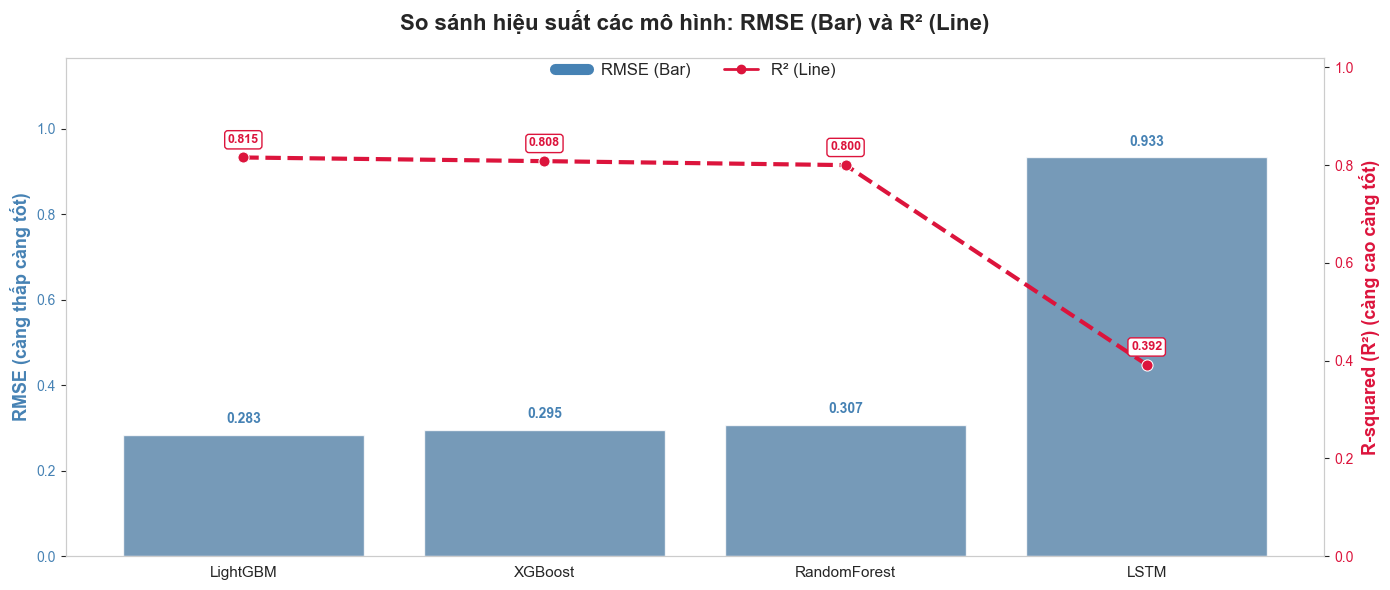

In [32]:

results = {
    'LightGBM':      {'RMSE': 0.2832, 'R2': 0.8154},
    'XGBoost':       {'RMSE': 0.2947, 'R2': 0.8079},
    'RandomForest':  {'RMSE': 0.3071, 'R2': 0.7998},
    'LSTM':          {'RMSE': 0.9331, 'R2': 0.3918}
}

metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})
metrics_df = metrics_df.sort_values('RMSE').reset_index(drop=True)


#sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 6))


sns.barplot(
    x='Model', y='RMSE',
    data=metrics_df,
    color='steelblue',
    alpha=0.8,
    ax=ax1
)

ax1.set_ylabel('RMSE (càng thấp càng tốt)', fontsize=13, color='steelblue', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xlabel('')
ax1.set_xticklabels(metrics_df['Model'], rotation=0, ha='center', fontsize=11)
ax1.set_ylim(0, metrics_df['RMSE'].max() * 1.25)

for i, v in enumerate(metrics_df['RMSE']):
    ax1.text(i, v + (metrics_df['RMSE'].max()*0.03), f'{v:.3f}',
             ha='center', fontsize=10, color='steelblue', fontweight='bold')


ax2 = ax1.twinx()

sns.lineplot(
    x='Model', y='R2',
    data=metrics_df,
    color='crimson',
    marker='o',
    linestyle='--',
    linewidth=3,
    markersize=8,
    ax=ax2
)

ax2.set_ylabel('R-squared (R²) (càng cao càng tốt)', fontsize=13, color='crimson', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.set_ylim(0, max(1.0, metrics_df['R2'].max() * 1.25))

for i, v in enumerate(metrics_df['R2']):
    ax2.text(i, v + 0.03, f'{v:.3f}',
             ha='center', fontsize=9, color='crimson',
             fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.25', facecolor='white', edgecolor='crimson', lw=1))

bar_proxy = plt.Line2D([0], [0], color='steelblue', lw=8, label='RMSE (Bar)')
line_proxy = plt.Line2D([0], [0], color='crimson', marker='o', lw=2, label='R² (Line)')
ax1.legend(handles=[bar_proxy, line_proxy],
           loc='upper center', bbox_to_anchor=(0.5, 1.02),
           fontsize=12, frameon=False, ncol=2)

ax1.set_title('So sánh hiệu suất các mô hình: RMSE (Bar) và R² (Line)',
              fontsize=16, fontweight='bold', pad=20)
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


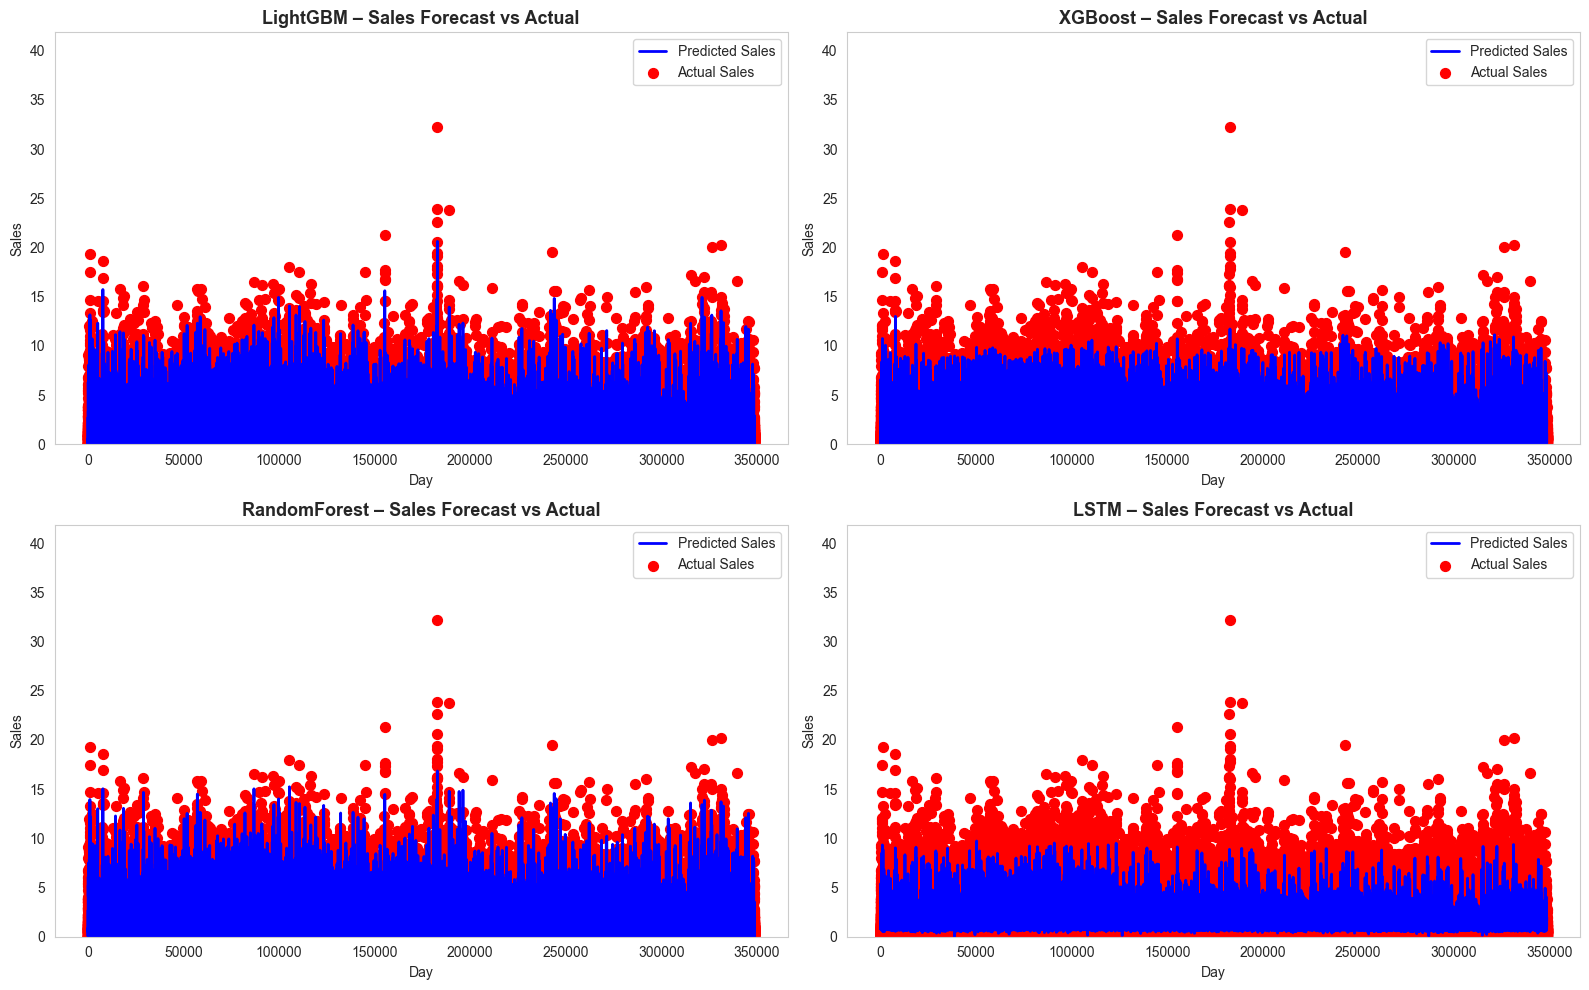

In [34]:

actual_tree = y_eval.values


actual_lstm = y_eval_aligned


pred_results = {
    "LightGBM": pred_lgb,
    "XGBoost": pred_xgb,
    "RandomForest": pred_rf,
    "LSTM": pred_lstm
}


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

models = ["LightGBM", "XGBoost", "RandomForest", "LSTM"]

for idx, model in enumerate(models):

    ax = axes[idx]

    # Predicted
    pred = pred_results[model]

    # Actual tuỳ model
    if model == "LSTM":
        actual = actual_lstm
    else:
        actual = actual_tree

    # X-axis
    days = np.arange(len(actual)) + 1

    # ============
    # PLOT STYLE
    # ============
    ax.plot(days, pred, color='blue', label='Predicted Sales', linewidth=2)
    ax.scatter(days, actual, color='red', label='Actual Sales', s=50)

    ax.set_title(f"{model} – Sales Forecast vs Actual", fontsize=13, fontweight='bold')
    ax.set_xlabel("Day")
    ax.set_ylabel("Sales")
    ax.set_ylim(0, max(max(pred), max(actual)) * 1.3)

    # Bỏ grid giống hình mẫu
    ax.grid(False)

    # Legend chỉ hiển thị 1 lần (đẹp hơn)
    #if idx == 0:
    ax.legend()

plt.tight_layout()
plt.show()


## **Phân tích model tốt nhất (LightGBM)**

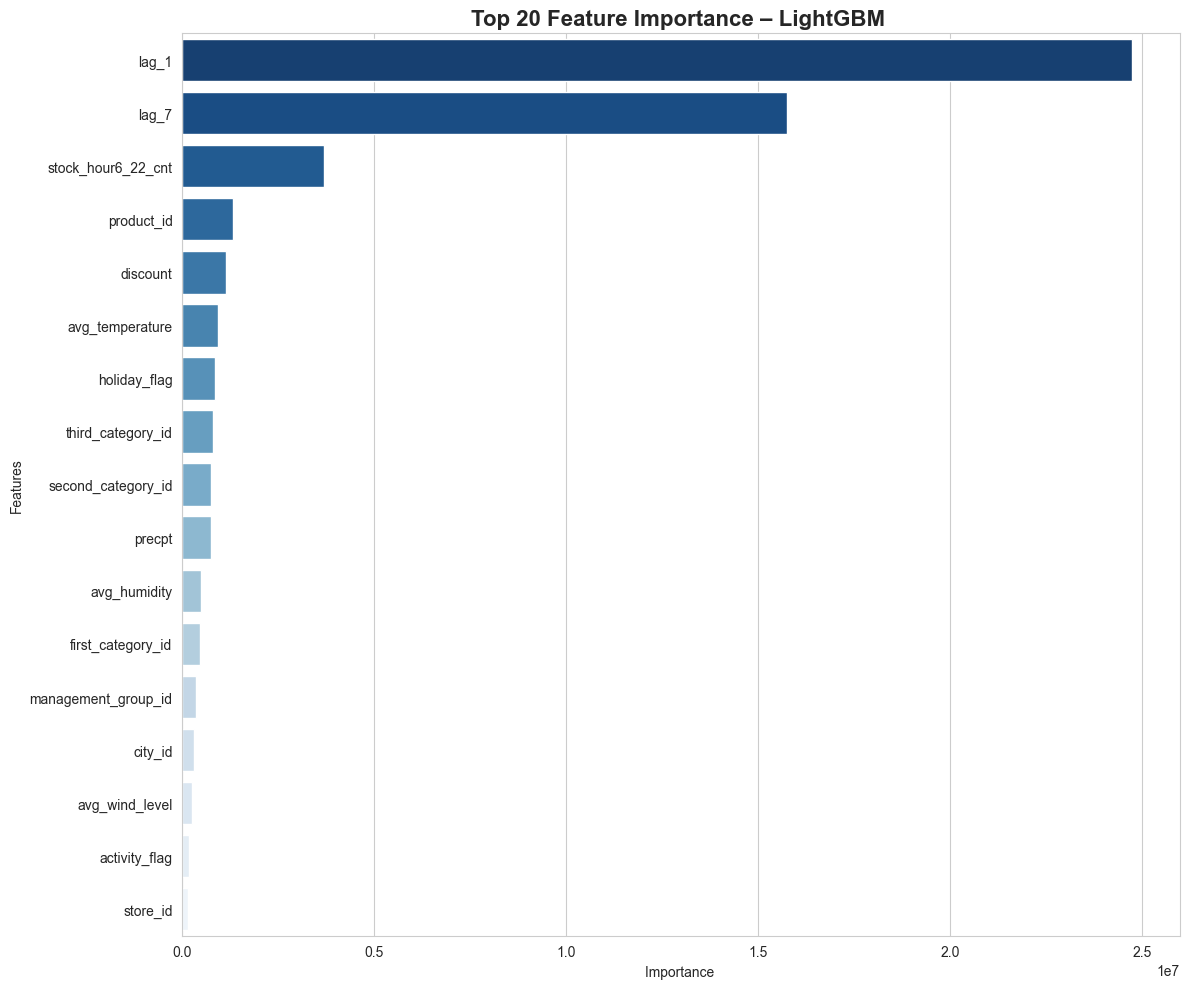

In [36]:

importance = model_lgb.feature_importance(importance_type='gain')
features = X_train.columns

df_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=df_imp.head(20), 
    x='Importance', 
    y='Feature', 
    palette='Blues_r'
)

plt.title("Top 20 Feature Importance – LightGBM ", fontsize=16, fontweight='bold')
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## Kết quả dự đoán của 1 product tại 1 store cụ thể

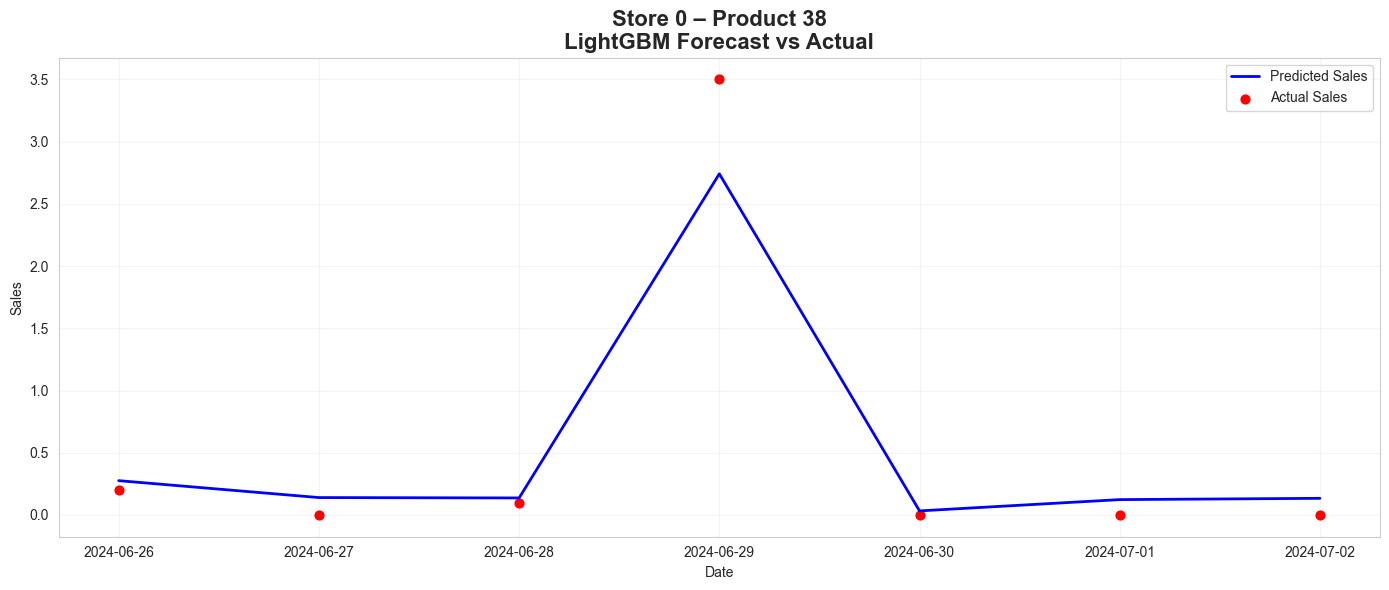

In [43]:
store_id = 0
product_id = 38

# Lọc đúng dữ liệu đánh giá của store & product
df_sub = df_eval[(df_eval['store_id'] == store_id) &
                 (df_eval['product_id'] == product_id)].copy()

df_sub = df_sub.sort_values("dt").reset_index(drop=True)

df_sub["pred_lgb"] = model_lgb.predict(
    df_sub[feature_cols],
    num_iteration=model_lgb.best_iteration
)


plt.figure(figsize=(14,6))

plt.plot(df_sub["dt"], df_sub["pred_lgb"], 
         color='blue', linewidth=2, label="Predicted Sales")

plt.scatter(df_sub["dt"], df_sub["sale_amount"], 
            color='red', s=40, label="Actual Sales")

plt.title(f"Store {store_id} – Product {product_id}\nLightGBM Forecast vs Actual",
          fontsize=16, fontweight="bold")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=0)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()
